In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = r'C:\Users\zhang\Desktop\md\linbo3\cal_viscosity\cry_1000p_out.lmp'

In [3]:
def read_frame(lines):
    data = []
    columns = []

    start_reading_data = False

    for line in lines:
        if line.startswith('ITEM: ATOMS'):
            columns = line.split()[2:]
            start_reading_data = True
        elif line.startswith('ITEM:'):
            start_reading_data = False
        elif start_reading_data:
            values = line.split()
            data.append(values)

    df = pd.DataFrame(data, columns=columns)
    numeric_columns = ['id', 'type', 'q', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'fx', 'fy', 'fz']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
    return df

In [4]:
# 用于存储所有帧的数据
frames = []

In [5]:
# 打开文件并逐行读取
with open(file_path, 'r') as file:
    lines = file.readlines()

    # 用于存储当前帧的数据
    current_frame_lines = []

    # 逐行解析数据
    for line in lines:
        if line.startswith('ITEM: TIMESTEP') and current_frame_lines:
            # 如果遇到新的时间步，将之前的数据作为一帧存储
            frames.append(read_frame(current_frame_lines))
            current_frame_lines = []
        current_frame_lines.append(line)

    # 处理文件结尾的最后一帧
    if current_frame_lines:
        frames.append(read_frame(current_frame_lines))

In [6]:
frames[0].tail

<bound method NDFrame.tail of           id  type    q           x          y          z        vx  \
0          1     1 -1.2   16.829231  18.785029   9.793018 -13.97960   
1          2     1 -1.2    9.657971   8.312819  14.352728  19.85310   
2          3     1 -1.2   95.122031  11.416129  51.504228  -4.13908   
3          4     1 -1.2  109.478831  19.901229   5.081988  15.86480   
4          5     1 -1.2   96.344731  18.138229  13.408628 -12.33580   
...      ...   ...  ...         ...        ...        ...       ...   
14995  14996     3  0.6   62.854731  21.823929  66.656228  -7.67868   
14996  14997     3  0.6   66.921531   0.121322   0.491618   2.96761   
14997  14998     3  0.6   57.059931   2.330069  55.789628  -5.91282   
14998  14999     3  0.6   67.321031   1.989489  70.104928  22.16480   
14999  15000     3  0.6   63.148931  20.443329   6.886758  26.12290   

              vy         vz        fx        fy        fz  
0       5.284320  28.450100  0.818885 -0.367172  0.615691

In [7]:
len(frames)

100

In [73]:
# 开始计算扩散系数D

In [77]:
# 步骤 1: 提取速度数据
def extract_velocity_data(frame):
    return frame[['vx', 'vy', 'vz']].values
# 步骤 2: 计算速度自相关函数
def velocity_autocorrelation(velocity_data,v0_data):
    num_atoms, num_dimensions = velocity_data.shape
    # print(num_atoms, num_dimensions)
    # autocorrelation = np.zeros((num_atoms, num_dimensions))
    sum_acf = 0
    for i in range(num_atoms):
        temp = np.dot(velocity_data[i],v0_data[i])
        # print(velocity_data[i],v0_data[i])
        sum_acf += temp
        # print(temp)
    return sum_acf / num_atoms


In [78]:
# 从每帧数据中提取速度
velocity_data_list = [extract_velocity_data(frame) for frame in frames]

In [83]:
acf_list = []
for i in range(100):
    temp = velocity_autocorrelation(velocity_data_list[i],velocity_data_list[0])
    acf_list.append(temp)
acf_list = np.array(acf_list)

In [84]:
acf_list = acf_list/acf_list[0]

In [80]:
velocity_autocorrelation(velocity_data_list[0],velocity_data_list[0])

399.67245333562045

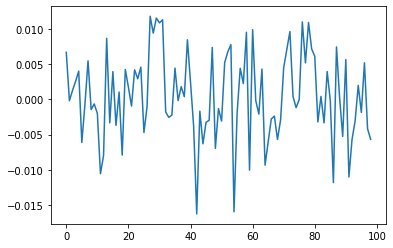

In [87]:
plt.plot(range(99),acf_list[1:])

# 对每个VAF进行积分

In [89]:


# Assuming you have lists for time and VAF
time = np.linspace(0,8,100)
vaf = acf_list

# Numerical integration using trapezoidal rule
integral_result = np.trapz(vaf, time)/3

print("Integrated result:", integral_result)


Integrated result: 0.014872344140588153


In [46]:
integral_result 

# 看一下势函数是什么样子





In [114]:
x_list = np.linspace(0.5,5,100)

In [115]:
# i = Si j=O 变量
Zi = 2.4
Zj = -1.2
e = 1.6* 1e-19
pi = 3.1415926
sigma = 8.854187818*1e-12
Aij =13702.9050
Bij = 28.950
Rij = 0.193817
Cij = 54.681
Dij = -3.059
nij = 3.932
ro = 1.168

In [116]:
def Pe(rij):
    if rij>ro:
        return  Zi*Zj*e*e/(4*pi*sigma*rij) + Aij*np.exp(-rij/Rij) - Cij/(rij**6)
    else:
        return Bij/(rij**nij) + Dij*(rij**2)

In [117]:
x_list = x_list
y_list = [ Pe(xi) for xi in x_list]

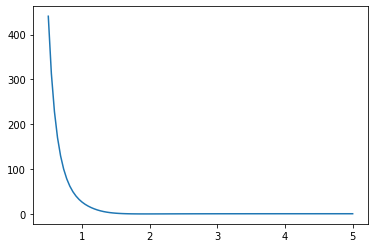

In [118]:
plt.plot(x_list,y_list)

# 采用Einstein relation计算扩散系数和黏度

In [8]:
def calculate_diffusion_coefficient(frames, box_size, timestep):
    num_frames = len(frames)
    num_atoms = len(frames[0])

    squared_displacements = np.zeros(num_atoms)

    for i in range(1, num_frames):
        for j in range(num_atoms):
            displacement = frames[i][j] - frames[0][j]
            # Consider periodic boundary conditions
            displacement = np.mod(displacement + 0.5 * box_size, box_size) - 0.5 * box_size
            squared_displacements[j] += np.sum(displacement**2)

    diffusion_coefficient = np.mean(squared_displacements) / (6 * num_frames * timestep)
    return diffusion_coefficient

In [33]:
a,b,c = 0,0,0
for index, i_atom in frames[0].iterrows():
    # print(i_atom)
    if i_atom['x']>a:
        a = i_atom['x']
    if i_atom['y']>b:
        b = i_atom['y']
    if i_atom['z']>c:
        c = i_atom['z']
print(a,b,c)    
box_size = np.array([a,b,c])

111.800831 23.676029 73.550728


In [27]:
# 从df中取出xyz数据的函数
def extract_xyz_data(frame):
    return frame[['x', 'y', 'z']].values

In [29]:
xyz_data = []
for i in range(len(frames)):
    temp_xyz = extract_xyz_data(frames[i])
    xyz_data.append(temp_xyz)
xyz_data = np.array(xyz_data)
print(xyz_data.shape)

(100, 15000, 3)


In [35]:
timestep = np.linspace(1e-4,8,100)

In [36]:
# 使用示例
# frames 是一个包含多帧的列表，每帧是一个包含原子坐标的二维数组
# box_size 是周期性边界的盒子大小
# timestep 是模拟的时间步长


diffusion_coefficient = calculate_diffusion_coefficient(xyz_data, box_size, timestep)
print("Diffusion Coefficient:", diffusion_coefficient)


Diffusion Coefficient: [7.19250829e+05 8.88983896e+02 4.44766811e+02 2.96572338e+02
 2.22452185e+02 1.77972757e+02 1.48316747e+02 1.27132386e+02
 1.11243295e+02 9.88846284e+01 8.89973891e+01 8.09076275e+01
 7.41660205e+01 6.84614850e+01 6.35718111e+01 5.93340400e+01
 5.56259493e+01 5.23540728e+01 4.94457132e+01 4.68434767e+01
 4.45014478e+01 4.23824561e+01 4.04560892e+01 3.86972234e+01
 3.70849222e+01 3.56015988e+01 3.42323717e+01 3.29645642e+01
 3.17873104e+01 3.06912430e+01 2.96682437e+01 2.87112418e+01
 2.78140502e+01 2.69712318e+01 2.61779892e+01 2.54300731e+01
 2.47237064e+01 2.40555205e+01 2.34225011e+01 2.28219432e+01
 2.22514123e+01 2.17087113e+01 2.11918524e+01 2.06990328e+01
 2.02286135e+01 1.97791011e+01 1.93491322e+01 1.89374594e+01
 1.85429392e+01 1.81645214e+01 1.78012400e+01 1.74522045e+01
 1.71165932e+01 1.67936461e+01 1.64826598e+01 1.61829818e+01
 1.58940064e+01 1.56151702e+01 1.53459489e+01 1.50858535e+01
 1.48344278e+01 1.45912454e+01 1.43559074e+01 1.41280404e+01
 

In [39]:
# 转换单位 a2/ns 到cm2/s 要乘以10-7
diffusion_coefficient = diffusion_coefficient*1e-7

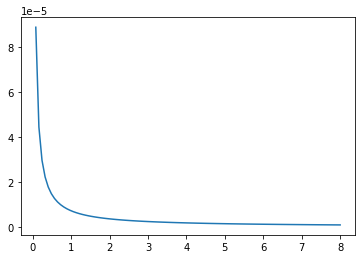

In [40]:
plt.plot(timestep[1:],diffusion_coefficient[1:])

In [47]:
# E-H计算黏度  先加入m值

# 假设你的DataFrame为 df，帧数的列为 'frame'，id 列为 'id'
# 创建一个新的列 'new_column'，并初始化为 None
for frame in frames:
    frame['m'] = None
    # 使用循环遍历 DataFrame，根据条件设置新列的值
    for index, row in frame.iterrows():
        if row['type'] == 1:
            frame.at[index, 'm'] = 16.0
        elif row['type'] == 2:
            frame.at[index, 'm'] = 92.91
        elif row['type'] == 3:
            frame.at[index, 'm'] = 6.941

In [48]:
frame.head

<bound method NDFrame.head of           id  type    q           x          y          z        vx  \
0          1     1 -1.2   16.625241  10.270713  68.051973   7.83922   
1          2     1 -1.2  102.797841  23.328713  50.311873  -4.47533   
2          3     1 -1.2   97.044841  12.836113  31.344473  19.05400   
3          4     1 -1.2   83.959441  16.609013  70.919173  -2.04431   
4          5     1 -1.2  107.148841   5.541943  62.663773   4.46394   
...      ...   ...  ...         ...        ...        ...       ...   
14995  14996     3  0.6  102.150441   4.745753   9.390893 -19.67040   
14996  14997     3  0.6   61.419141  12.236113  16.954373   4.98196   
14997  14998     3  0.6   95.225741   9.073453  20.007273 -11.19490   
14998  14999     3  0.6   66.212441  10.073183  64.054873  -7.46630   
14999  15000     3  0.6  104.584841   8.687813  55.160073 -17.48930   

              vy         vz        fx        fy        fz      m  
0      12.867400  12.835600  0.922777  0.863851  4

In [49]:
# 常量
Kb = 1.38*1e-23
T = 300
V = a*b*c

In [56]:
# 从df中取出 x,y,z数据的函数
def extract_need_data(frame):
    return frame[['x', 'y', 'z','vy','m']].values

In [59]:
need_data = []
for i in range(len(frames)):
    temp_xyz = extract_need_data(frames[i])
    need_data.append(temp_xyz)
need_data = np.array(need_data)
print(need_data.shape)

(100, 15000, 5)


In [60]:
need_data[0][0]

array([16.829231, 18.785029, 9.793018, 5.28432, 16.0], dtype=object)

In [78]:
def calculate_viscosity(frames, box_size, timestep):
    num_frames = len(frames)
    num_atoms = len(frames[0])
    
    frame_0 = frames[0]
    
    viscosity_list = np.zeros(num_frames)

    for i in range(1, num_frames):
        for j in range(num_atoms):
            # 原子
            temp_atom = frames[i][j]
            temp_atom0 = frame_0[j]
            # print(temp_atom)
            # x*m*vy - x0*m0*vy0
            #print(temp_atom0)
            value = temp_atom[0]*temp_atom[3]*temp_atom[4] - temp_atom0[0]*temp_atom0[3]*temp_atom0[4] 
            
            viscosity_list[i] += value**2
    viscosity_list = viscosity_list/(2*Kb*T*V*num_atoms)
    return viscosity_list

In [80]:
vis_list = calculate_viscosity(need_data, box_size, timestep)

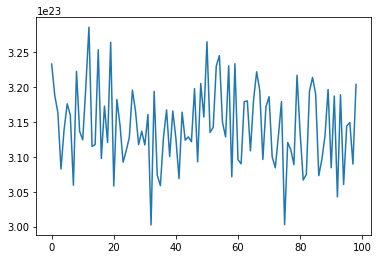

In [82]:
plt.plot(range(len(vis_list[1:])),vis_list[1:])

# 感觉不能用速度来计算黏度，而是应该用位移来计算黏度
# 因为在模拟中，速度只跟温度有关系，即温度相同粒子运动速率是一定相同的
# 但是粒子的运动情况却并不是速率能够表现出来的 位移更加能够代表这种性质
# 即应该尝试采用位移的方法计算黏度